## Try-outs for cell counting - *Haematococcus*

The main goal is a system for algae counting in a microscope image. To reach this, we have some short tasks, as 1) figure upload, 2) determine what a single cell is, and 3) count. Ok, should be fair easy! :)

Here are some interesting reading (also because this example was based on *scikit-image* package tutorials):

http://scikit-image.org/docs/stable/auto_examples/index.html

https://github.com/brikeats/Image-Analysis-in-Python/blob/master/Intro%20to%20Image%20Analysis%20in%20Python.ipynb

http://morphogenie.fr/segmenting-nuclei.html

### Counting algae - microscopy

Counting algae cells in a microscope image may sounds archaic, but still is one of the main parameters for microalgae analysis, from ecotoxicology tests to integral environment evaluations. In any way, it usually is one of the most sad and morous tasks one has to accomplish in algae research. This is due to the number of samples, or to the number of cells that has to be count in each sample - and that is on statistics. Imagine staying seated, on microscope, counting single-celled algae for 8 hours a day, for 2 weeks. No, it isn't difficult, but it brings inherently, two major problems: tiredness-related errors because of the human (lack of) plasticity, and it is time-consuming.

Therefore, algae researchers urge for automatization, and the easiest way is processing the images taken from a microscope.

For this try-out I'll use images from *Haematococcus pluvialis* and *Euglena mutabilis*, both strains are mantained and used in research at the Phycology Lab at Federal University of Santa Catarina (UFSC).

(you'll only find one algae here, the other is in the other notebook, ok? Just go back to the repo and find the euglena_rev jupyter notebook).

### Algae background

*Haematococcus pluvialis* (HPL): Chlorophyceae highly studied for industrial-scale astaxanthin production, this strain has a complicated life-cycle, with at least 5 different phases - and consequently, formats. Palmella, akinete, macrozoospore, microzoospore, plus the asexual reproduction. We have tried using an hematocitometer-analyzer, and its output is a scatter plot with cell complexity. Is nice and publishable, but it doesn't solve much about the HPL cell type for a practical reason, and one of the constraints of this equipment is that it can not deal with a wide range of cell sizes - which is all HPL is about.


### Basic fluxogram

Pre-treatment:
- Load image
- Gray scale
- Gaussian filter
- Threshold for binarization

Morphological operations:
- Small objects removal
- Find local maxima

Rework:
- Centroids
- Clusters

Because this is a first try, I will ignore the HPL's multiple cell type. We will get to it in a further example...

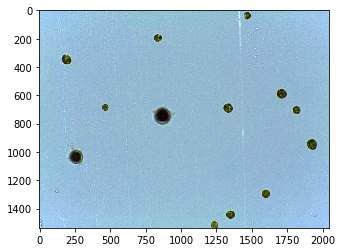

In [1]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

im = plt.imread('images/counting_hpl_1.jpg')

plt.imshow(im)

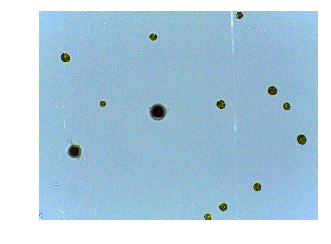

In [2]:
# defining parameters for imshow

def my_imshow(im, title=None, **kwargs):
    if 'cmap' not in kwargs:
        kwargs['cmap'] = 'gray'
    plt.figure(figsize=(5,5))
    plt.imshow(im, interpolation='none', **kwargs)
    if title:
        plt.title(title)
    plt.axis('off')

#print ('original image shape: {}'.format(im.shape))
#print ('alpha channel intensity: {0:.2f} +- {1:.2f}'.format(np.mean(im[:,:,-1]), np.std(im[:,:,-1])))
my_imshow(im)

First, convert from color (4 channel, actually) to grayscale.

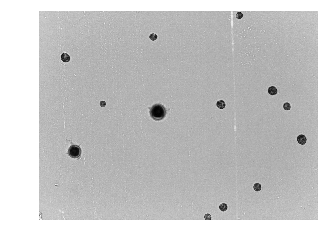

In [3]:
from skimage import color

# convert to gray 

gray_im = color.rgb2gray(im)

#print ('grayscale image shape:', gray_im.shape)

my_imshow(gray_im)

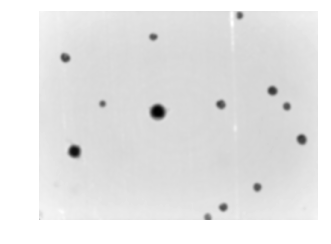

In [4]:
# blur to reduce noise using a gaussian filter

from skimage import filters
blurred_im = filters.gaussian(gray_im, sigma=10)
my_imshow(blurred_im)

Pre-processing finished, we can threshold it to convert it to a cell mask.
This will have an binary output, which will be important for our next steps.

This is the first piece of code that it will visually make sense. And because of that, here we can start to play with it.

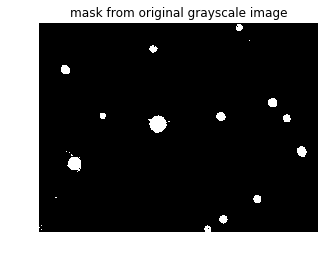

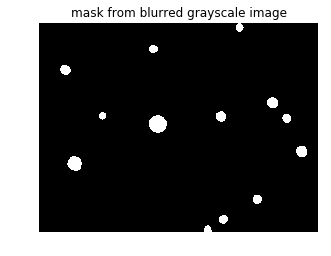

In [5]:
thresh = 0.6

# for example, go and try to change the thresh parameter.

mask = gray_im < thresh
blurred_mask = blurred_im < thresh

my_imshow(mask, title='mask from original grayscale image')
my_imshow(blurred_mask, title='mask from blurred grayscale image')
# smooth!

Binary images can be manipulated with morphological operations. Morphological operations allow us to expand or shrink the white regions, fill in holes, and more. In this case, we simply want to remove the tiny dots.

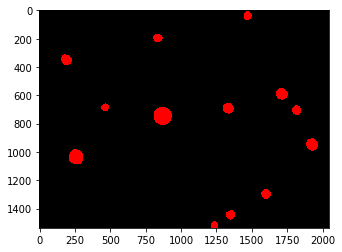

In [6]:
from skimage import feature, measure
from matplotlib.colors import ListedColormap

def imshow_overlay(im, mask, alpha=0.5, color='red', **kwargs):
    """Show semi-transparent red mask over an image"""
    mask = mask > 0
    mask = np.ma.masked_where(~mask, mask)        
    plt.imshow(im, **kwargs)
    plt.imshow(mask, alpha=alpha, cmap=ListedColormap([color]))


peaks_im = feature.peak_local_max(blurred_mask, indices=False)

#plt.figure()
#imshow_overlay(blurred_mask[600:900, 600:1000], peaks_im[600:900, 600:1000], alpha=1, cmap='gray')

plt.figure()
imshow_overlay(blurred_mask, peaks_im, alpha=1, cmap='gray')

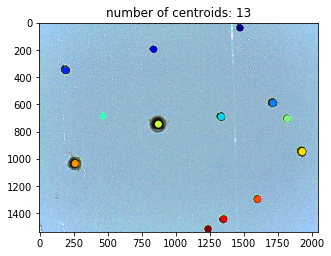

In [8]:
markers_im = measure.label(peaks_im)

properties = measure.regionprops(markers_im)
hpl_centroids = [prop.centroid for prop in properties]

hpl_array = np.asarray(hpl_centroids)

plt.figure(figsize=(5,5))
plt.imshow(im, interpolation='none', cmap='jet')

num_centroids =len(hpl_centroids)

plt.scatter(hpl_array[:,1], hpl_array[:,0], c=range(0, num_centroids), cmap='jet')


title = "number of centroids: %d" % (num_centroids )

plt.title(title)
plt.show()